Train path exists? True
Test path exists? True
Shape predictor exists? True
ResNet model exists? True
Acurácia LBPH: 0.8


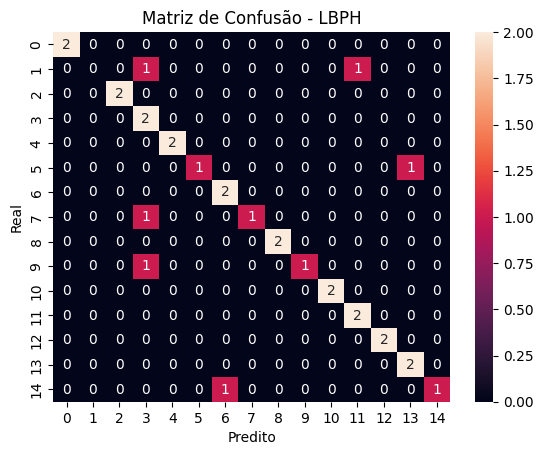

Acurácia com Dlib + ResNet: 1.0


In [ ]:
# CODIG Acurácia com Dlib + ResNet: 1.0
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import dlib

# ----- Caminhos (atualize conforme seu diretório) -----
base_dir = r'C:\Users\user\Downloads\Computer_Vision\2_Rec_Face\1_Rec_Face'
train_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'train')
test_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'test')
shape_predictor_path = os.path.join(base_dir, 'Weights', 'shape_predictor_68_face_landmarks.dat')
resnet_model_path = os.path.join(base_dir, 'Weights', 'dlib_face_recognition_resnet_model_v1.dat')

# ----- Verificação rápida de caminhos -----
print("Train path exists?", os.path.exists(train_path))
print("Test path exists?", os.path.exists(test_path))
print("Shape predictor exists?", os.path.exists(shape_predictor_path))
print("ResNet model exists?", os.path.exists(resnet_model_path))

# ----- Função para carregar e redimensionar imagens para LBPH -----
def get_image_data(path, size=(100, 100)):
    faces = []
    ids = []
    for f in os.listdir(path):
        image_path = os.path.join(path, f)
        image = Image.open(image_path).convert('L')
        image = image.resize(size)  # Redimensiona para 100x100
        image_np = np.array(image, 'uint8')
        # Extrai id do nome do arquivo, ex: "subject01.sad"
        id = int(f.split('.')[0].replace('subject', ''))
        faces.append(image_np)
        ids.append(id)
    return np.array(ids), faces

# ----- Carrega dados de treino -----
ids, faces = get_image_data(train_path)

# ----- Treinamento LBPH -----
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius=4, neighbors=14, grid_x=9, grid_y=9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

# ----- Teste LBPH -----
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('lbph_classifier.yml')

test_files = os.listdir(test_path)
previsoes = []
saidas_esperadas = []

for f in test_files:
    img_path = os.path.join(test_path, f)
    image = Image.open(img_path).convert('L')
    image = image.resize((100, 100))
    image_np = np.array(image, 'uint8')
    pred, _ = lbph_face_classifier.predict(image_np)
    real = int(f.split('.')[0].replace('subject', ''))
    previsoes.append(pred)
    saidas_esperadas.append(real)

acc = accuracy_score(saidas_esperadas, previsoes)
print("Acurácia LBPH:", acc)

# ----- Matriz de Confusão LBPH -----
cm = confusion_matrix(saidas_esperadas, previsoes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Matriz de Confusão - LBPH")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

# ----- Inicialização Dlib -----
detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor(shape_predictor_path)
descritor_facial_extrator = dlib.face_recognition_model_v1(resnet_model_path)

# ----- Extração dos descritores faciais do conjunto de treino -----
descritores_faciais = []
index = {}
idx = 0

for f in os.listdir(train_path):
    path_img = os.path.join(train_path, f)
    image = Image.open(path_img).convert('RGB')
    image_np = np.array(image)
    detec = detector_face(image_np, 1)
    for face in detec:
        pontos = detector_pontos(image_np, face)
        descritor = descritor_facial_extrator.compute_face_descriptor(image_np, pontos)
        descritor = np.array(descritor, dtype=np.float64)[np.newaxis, :]
        descritores_faciais.append(descritor)
        index[idx] = path_img
        idx += 1

descritores_faciais = np.vstack(descritores_faciais)

# ----- Avaliação com Dlib + distância Euclidiana -----
previsoes_dlib = []
saidas_dlib = []

for f in os.listdir(test_path):
    img_path = os.path.join(test_path, f)
    image = Image.open(img_path).convert('RGB')
    image_np = np.array(image)
    detec = detector_face(image_np, 1)
    for face in detec:
        pontos = detector_pontos(image_np, face)
        descritor = descritor_facial_extrator.compute_face_descriptor(image_np, pontos)
        descritor = np.array(descritor, dtype=np.float64)[np.newaxis, :]
        distancias = np.linalg.norm(descritor - descritores_faciais, axis=1)
        idx_min = np.argmin(distancias)
        if distancias[idx_min] <= 0.5:
            pred_name = int(os.path.basename(index[idx_min]).split('.')[0].replace('subject', ''))
        else:
            pred_name = -1
        real = int(f.split('.')[0].replace('subject', ''))
        previsoes_dlib.append(pred_name)
        saidas_dlib.append(real)

acc_dlib = accuracy_score(saidas_dlib, previsoes_dlib)
print("Acurácia com Dlib + ResNet:", acc_dlib)


In [ ]:
# MOSTRAR PONTOS NA IMG_FACE
import os
import numpy as np
import cv2
from PIL import Image
import dlib

index = {}
idx = 0
descritores_faciais = None

# ----- Caminhos (atualize conforme seu diretório) -----
base_dir = r'C:\Users\user\Downloads\Computer_Vision\2_Rec_Face\1_Rec_Face'
train_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'train')
test_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'test')
shape_predictor_path = os.path.join(base_dir, 'Weights', 'shape_predictor_68_face_landmarks.dat')
resnet_model_path = os.path.join(base_dir, 'Weights', 'dlib_face_recognition_resnet_model_v1.dat')

# ----- Verificação rápida de caminhos -----
print("Train path exists?", os.path.exists(train_path))
print("Test path exists?", os.path.exists(test_path))
print("Shape predictor exists?", os.path.exists(shape_predictor_path))
print("ResNet model exists?", os.path.exists(resnet_model_path))

# ----- Inicializa Dlib -----
detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor(shape_predictor_path)
descritor_facial_extrator = dlib.face_recognition_model_v1(resnet_model_path)

# ----- Itera pelas imagens de treino -----
paths = [os.path.join(train_path, f) for f in os.listdir(train_path)]
for path in paths:
    imagem = Image.open(path).convert('RGB')
    imagem_np = np.array(imagem, 'uint8')
    deteccoes = detector_face(imagem_np, 1)

    for face in deteccoes:
        l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
        cv2.rectangle(imagem_np, (l, t), (r, b), (0, 0, 255), 2)

        pontos = detector_pontos(imagem_np, face)
        for ponto in pontos.parts():
            cv2.circle(imagem_np, (ponto.x, ponto.y), 2, (0, 255, 0), 1)

        descritor_facial = descritor_facial_extrator.compute_face_descriptor(imagem_np, pontos)
        descritor_facial = np.asarray(descritor_facial, dtype=np.float64)[np.newaxis, :]

        if descritores_faciais is None:
            descritores_faciais = descritor_facial
        else:
            descritores_faciais = np.concatenate((descritores_faciais, descritor_facial), axis=0)

        index[idx] = path
        idx += 1

    # ----- Visualiza imagem -----
    cv2.imshow('Imagem com pontos faciais', imagem_np)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Train path exists? True
Test path exists? True
Shape predictor exists? True
ResNet model exists? True


In [ ]:
# CODIGO COM  descritores_faciais AND descritores_faciais.shape
import os
import numpy as np
import cv2
from PIL import Image
import dlib

index = {}
idx = 0
descritores_faciais = None

# ----- Caminhos (atualize conforme seu diretório) -----
base_dir = r'C:\Users\user\Downloads\Computer_Vision\2_Rec_Face\1_Rec_Face'
train_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'train')
test_path = os.path.join(base_dir, 'Datasets', 'yalefaces', 'test')
shape_predictor_path = os.path.join(base_dir, 'Weights', 'shape_predictor_68_face_landmarks.dat')
resnet_model_path = os.path.join(base_dir, 'Weights', 'dlib_face_recognition_resnet_model_v1.dat')

# ----- Verificação rápida de caminhos -----
print("Train path exists?", os.path.exists(train_path))
print("Test path exists?", os.path.exists(test_path))
print("Shape predictor exists?", os.path.exists(shape_predictor_path))
print("ResNet model exists?", os.path.exists(resnet_model_path))

# ----- Inicializa Dlib -----
detector_face = dlib.get_frontal_face_detector()
detector_pontos = dlib.shape_predictor(shape_predictor_path)
descritor_facial_extrator = dlib.face_recognition_model_v1(resnet_model_path)

# ----- Itera pelas imagens de treino -----
paths = [os.path.join(train_path, f) for f in os.listdir(train_path)]
for path in paths:
    imagem = Image.open(path).convert('RGB')
    imagem_np = np.array(imagem, 'uint8')
    deteccoes = detector_face(imagem_np, 1)

    for face in deteccoes:
        l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
        cv2.rectangle(imagem_np, (l, t), (r, b), (0, 0, 255), 2)

        pontos = detector_pontos(imagem_np, face)
        for ponto in pontos.parts():
            cv2.circle(imagem_np, (ponto.x, ponto.y), 2, (0, 255, 0), 1)

        descritor_facial = descritor_facial_extrator.compute_face_descriptor(imagem_np, pontos)
        descritor_facial = np.asarray(descritor_facial, dtype=np.float64)[np.newaxis, :]

        if descritores_faciais is None:
            descritores_faciais = descritor_facial
        else:
            descritores_faciais = np.concatenate((descritores_faciais, descritor_facial), axis=0)

        index[idx] = path
        idx += 1

    # ----- Visualiza imagem com pontos -----
    cv2.imshow('Imagem com pontos faciais', imagem_np)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# ----- Após processar todas as imagens -----
if descritores_faciais is not None:
    print("\nShape do array descritores_faciais:", descritores_faciais.shape)

    # Configura exibição
    np.set_printoptions(precision=4, suppress=True, linewidth=150)

    print("\nPrimeiros 5 descritores faciais:")
    print(descritores_faciais[:5])
